In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Climate_data.csv')

In [3]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
0,2013-01-01,0.122271,0.840372,0.000000,0.132603,0.0,0.0,0.000000,0.166667
1,2013-01-02,0.042795,0.929054,0.070583,0.132881,0.0,0.0,0.033333,0.333333
2,2013-01-03,0.035662,0.869932,0.109743,0.132994,0.0,0.0,0.066667,0.500000
3,2013-01-04,0.081514,0.684685,0.029212,0.132799,0.0,0.0,0.100000,0.666667
4,2013-01-05,0.000000,0.867962,0.087636,0.132712,0.0,0.0,0.133333,0.833333


In [4]:
train = data[:-180]
test = data[-180:]
print(train.shape)
print(test.shape)

(1395, 9)
(180, 9)


In [5]:
x_train = train.drop(columns = {'date','meantemp'}, axis = 1)
y_train = train.loc[:, ['meantemp']]

x_test = test.drop(columns = {'date','meantemp'}, axis = 1)
y_test = test.loc[:, ['meantemp']]

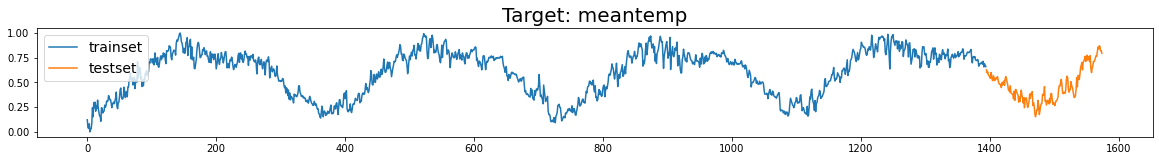

In [6]:
sns.reset_orig()
plt.figure(figsize = (20,2))
plt.title('Target: meantemp', fontsize = 20)
plt.plot(y_train['meantemp'], label = 'trainset')
plt.plot(y_test['meantemp'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

# LightGBM

In [7]:
import lightgbm as lgb

In [8]:
model = lgb.LGBMRegressor().fit(x_train, y_train)

pred = model.predict(x_test)
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)

print('R2: ', r2, '  ;  ', 'MSE: ', mse)

R2:  0.7814408856481162   ;   MSE:  0.008271250694535643


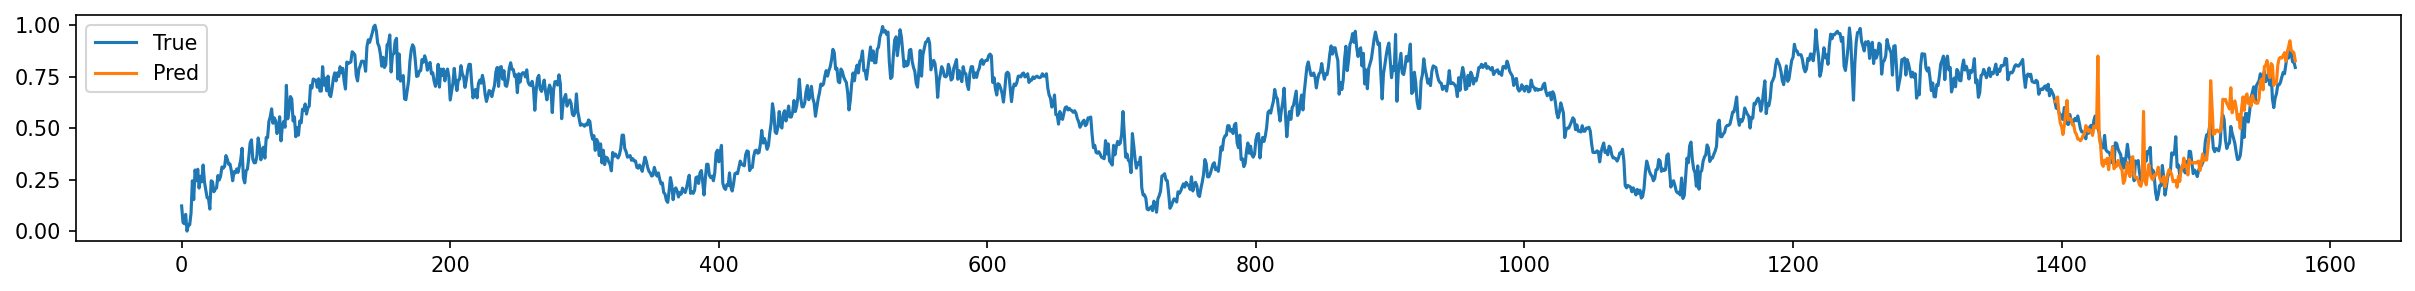

In [9]:
prediction = pd.DataFrame(pred, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,2), dpi=150)

plt.plot(data['meantemp'], label = 'True')
plt.plot(prediction, label = 'Pred')

plt.legend()

plt.show()

# Interpretation of LightGBM

In [10]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [11]:
# The training set is evenly divided into 11 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 8
interp_x= x_train
model = model

ShapTime_lgb = ShapleyValues(model, interp_x, Tn)

In [12]:
ShapTime_lgb

[-0.012461220892220334,
 0.003985234530871604,
 -0.041053474239185615,
 0.03391227164457228,
 -0.05451358583048289,
 0.046430979020581936,
 -0.0464967784101408,
 0.0712799978148201]

In [13]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

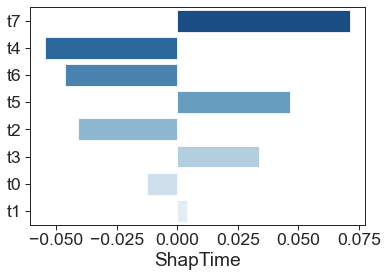

In [14]:
TimeImportance(Tn, ShapTime_lgb, time_columns)

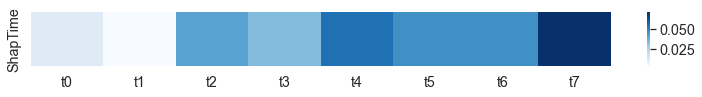

In [15]:
TimeHeatmap(Tn, ShapTime_lgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [16]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [17]:
n = 3
Tn = 8
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_lgb
model = lgb.LGBMRegressor()

In [18]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

In [19]:
result

,t0,t1,t2,t3,t4,t5,t6,t7
0,-0.012461,0.003985,-0.041053,0.033912,-0.054514,0.046431,-0.046497,0.071280
1,-0.012922,0.004410,-0.041105,0.033334,-0.053869,0.045953,-0.046726,0.071962
2,-0.012420,0.004069,-0.040990,0.033152,-0.054192,0.046415,-0.046788,0.071797
3,-0.012857,0.004517,-0.040368,0.032927,-0.054575,0.046440,-0.047240,0.072243


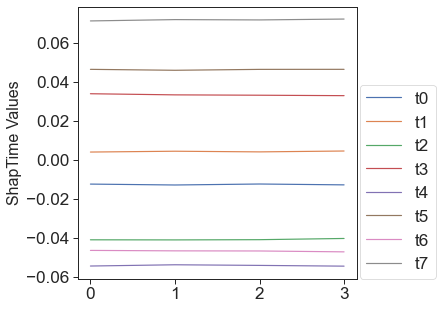

In [20]:
PlotVal(result)

### Sensitivity

In [21]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7]
situation_1 = [0, 1, 2, 3, 4, 5, 6, 1]
situation_2 = [0, 1, 2, 3, 0, 5, 6, 1]

In [22]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'date')
df_eva = supertime(8, train_eva)
model_eva = lgb.LGBMRegressor()

In [23]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [24]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'meantemp', model_eva, total)

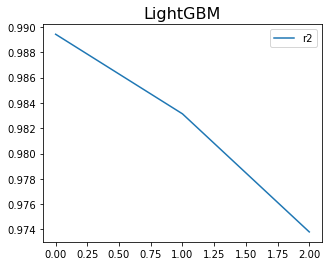

In [25]:
R2Plot(r2_results, 'LightGBM')

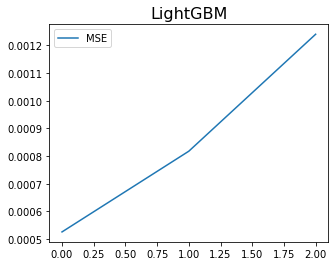

In [26]:
MSEPlot(mse_results, 'LightGBM')

# Improvement

In [27]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [28]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [29]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]

model_check = lgb.LGBMRegressor().fit(x_check, y_check)

pred_check = model_check.predict(x_test)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

0.7847757866392302 Degree of Improvement: 0.43%
0.008232901303202485 Degree of Improvement: 0.46%


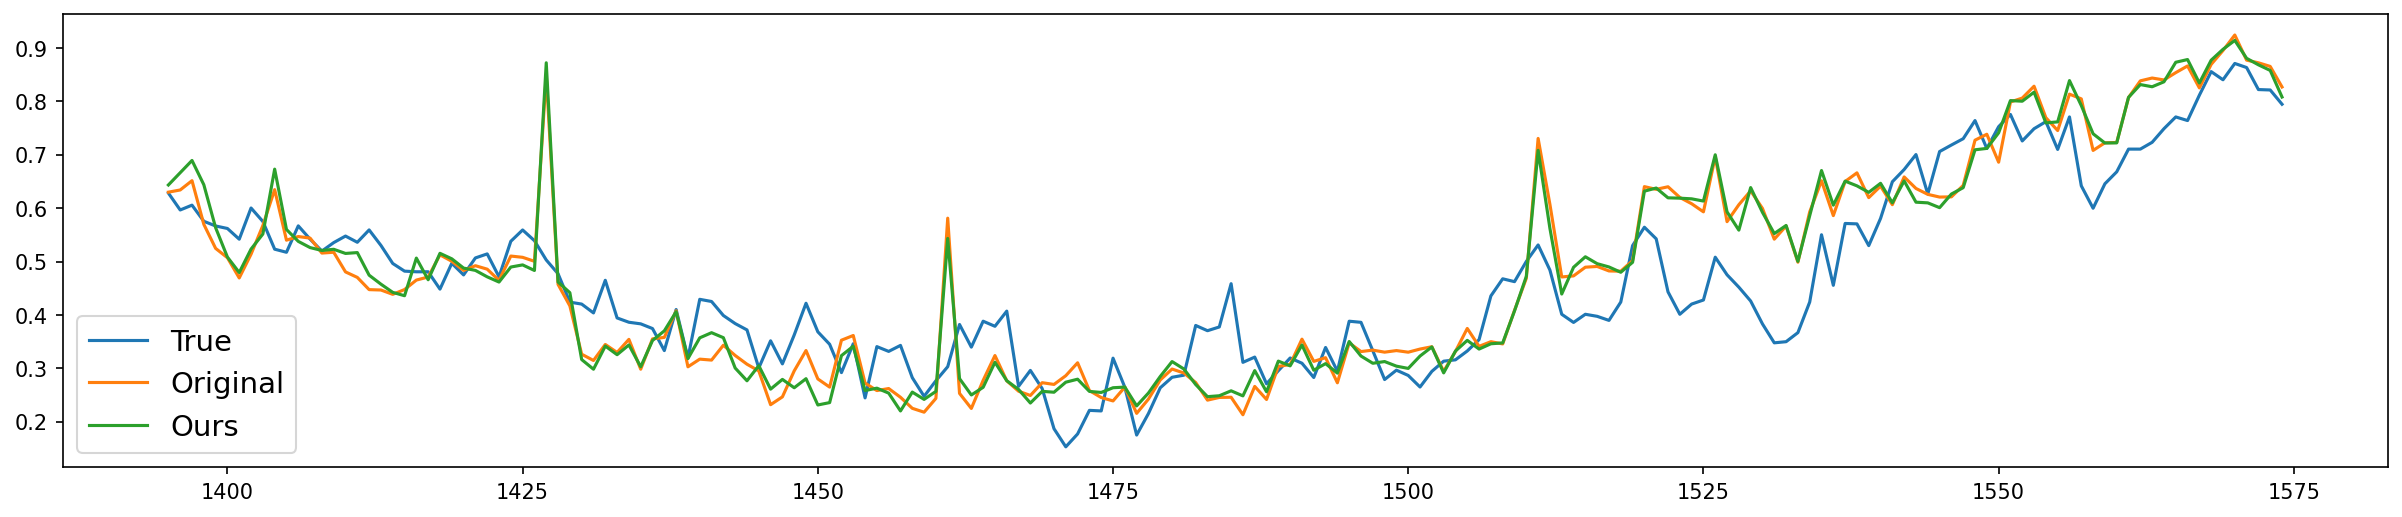

In [30]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['meantemp'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()